In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime

from PPO import PPO

from PPO_MINI import PPO as PPO_MINI

from rocket import Rocket
from tqdm.auto import tqdm


Device set to : NVIDIA GeForce RTX 2070 with Max-Q Design
Device set to : NVIDIA GeForce RTX 2070 with Max-Q Design


### Environment

In [2]:
max_ep_len=1000
env_name="RocketLanding"
task="landing"
# Initialize Rocket environment
env = Rocket(max_steps=max_ep_len, task=task, rocket_type="starship")

### Training logic

In [3]:
def train(
    agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=6_000_000,
    render=False,
    max_ep_len=1000,
    print_freq=None,
    log_freq=None,
    save_model_freq=100_000,
    update_timestep=None,
    random_seed=0,
):
    """
    Train an agent on the Rocket environment.
    Returns the list of `episode_rewards` for later offline plotting.
    """

    if print_freq is None:
        print_freq = max_ep_len * 10  # e.g. 10000
    if log_freq is None:
        log_freq = max_ep_len * 2  # e.g. 2000
    if update_timestep is None:
        update_timestep = max_ep_len * 4  # e.g. 4000

    # Setup logging directory
    log_dir = "PPO_logs"
    os.makedirs(log_dir, exist_ok=True)
    log_dir = os.path.join(log_dir, env_name)
    os.makedirs(log_dir, exist_ok=True)

    run_num = len(next(os.walk(log_dir))[2])  # counting files for naming
    log_f_name = os.path.join(log_dir, f"PPO_{env_name}_log_{run_num}.csv")
    print("Logging at :", log_f_name)

    # Setup checkpoint directory
    directory = "PPO_preTrained"
    os.makedirs(directory, exist_ok=True)
    directory = os.path.join(directory, env_name)
    os.makedirs(directory, exist_ok=True)

    checkpoint_path = os.path.join(
        directory, f"PPO_{env_name}_{random_seed}_{run_num}.pth"
    )
    print("Save checkpoint path :", checkpoint_path)

    # Track time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    # Open log file
    log_f = open(log_f_name, "w+")
    log_f.write("episode,timestep,reward\n")

    # Some tracking variables
    print_running_reward = 0.0
    print_running_episodes = 0
    log_running_reward = 0.0
    log_running_episodes = 0

    time_step = 0
    i_episode = 0

    episode_rewards = []
    window_size = 10  # for smoothing the plot

    # Main training loop

    pbar = tqdm(total=max_training_timesteps, desc="Training Timesteps")

    while time_step <= max_training_timesteps:
        state = env.reset()
        current_ep_reward = 0.0

        for t in range(1, max_ep_len + 1):
            # Select action
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action)

            # Log to PPO buffer
            agent.buffer.rewards.append(reward)
            agent.buffer.is_terminals.append(done)

            time_step += 1
            current_ep_reward += reward
            pbar.update(1)

            # Render if needed
            if render and i_episode % 50 == 0:
                env.render()

            # Update PPO
            if time_step % update_timestep == 0:
                agent.update()

            # Logging
            if time_step % log_freq == 0:
                if log_running_episodes > 0:
                    log_avg_reward = log_running_reward / log_running_episodes
                else:
                    log_avg_reward = 0
                log_f.write(
                    "{},{},{}\n".format(i_episode, time_step, round(log_avg_reward, 4))
                )
                log_running_reward, log_running_episodes = 0.0, 0

            # Print average reward
            if time_step % print_freq == 0:
                if print_running_episodes > 0:
                    print_avg_reward = print_running_reward / print_running_episodes
                else:
                    print_avg_reward = 0
                print(
                    f"Episode : {i_episode} \t\t"
                    f"Timestep : {time_step} \t\t"
                    f"Average Reward : {round(print_avg_reward, 2)}"
                )
                print_running_reward, print_running_episodes = 0.0, 0

            # Save model
            if time_step % save_model_freq == 0:
                agent.save(checkpoint_path)
                print("Model saved at timestep:", time_step)

            if done:
                break

        # End of episode
        print_running_reward += current_ep_reward
        print_running_episodes += 1
        log_running_reward += current_ep_reward
        log_running_episodes += 1
        i_episode += 1

        episode_rewards.append(current_ep_reward)

    pbar.close()
    log_f.close()

    end_time = datetime.now().replace(microsecond=0)
    print("Finished training at : ", end_time)
    print("Total training time  : ", end_time - start_time)

    return episode_rewards

### Experiments

#### Comparison of PPO Agent vs PPO Agent with minibatch

In [4]:
# State and action dimensions
state_dim = env.state_dims
action_dim = env.action_dims

lr_actor = 0.0003
lr_critic = 0.001
K_epochs = 80
eps_clip = 0.2
gamma = 0.99
has_continuous_action_space = False

ppo_agent = PPO(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
)

ppo_minibatch_agent = PPO_MINI(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
    mini_batch_size=64,  # example
)

episode_rewards_ppo = train(
    ppo_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=1e5,
)


episode_rewards_ppo_mini = train(
    ppo_minibatch_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=1e5,
)

Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_4.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_4.pth
Started training at (GMT) :  2025-03-19 14:25:36


Training Timesteps:   0%|          | 0/100000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -221.69
Episode : 92 		Timestep : 20000 		Average Reward : -200.92
Episode : 140 		Timestep : 30000 		Average Reward : -164.15
Episode : 189 		Timestep : 40000 		Average Reward : -130.4
Episode : 236 		Timestep : 50000 		Average Reward : -126.75
Episode : 283 		Timestep : 60000 		Average Reward : -167.36
Episode : 330 		Timestep : 70000 		Average Reward : -252.19
Episode : 379 		Timestep : 80000 		Average Reward : -210.41
Episode : 428 		Timestep : 90000 		Average Reward : -118.08
Episode : 475 		Timestep : 100000 		Average Reward : -169.78
Model saved at timestep: 100000
Finished training at :  2025-03-19 14:27:57
Total training time  :  0:02:21
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_5.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_5.pth
Started training at (GMT) :  2025-03-19 14:27:57


Training Timesteps:   0%|          | 0/100000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -147.48
Episode : 98 		Timestep : 20000 		Average Reward : -130.63
Episode : 147 		Timestep : 30000 		Average Reward : -107.38
Episode : 195 		Timestep : 40000 		Average Reward : -82.8
Episode : 244 		Timestep : 50000 		Average Reward : -70.25
Episode : 293 		Timestep : 60000 		Average Reward : -45.23
Episode : 344 		Timestep : 70000 		Average Reward : -23.07
Episode : 393 		Timestep : 80000 		Average Reward : -42.33
Episode : 443 		Timestep : 90000 		Average Reward : -0.09
Episode : 494 		Timestep : 100000 		Average Reward : 12.19
Model saved at timestep: 100000
Finished training at :  2025-03-19 14:37:54
Total training time  :  0:09:57


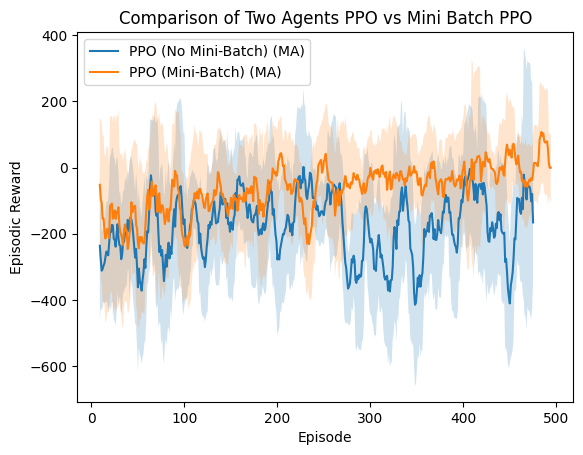

In [8]:
window_size = 10
rewards_agent1 = episode_rewards_ppo
rewards_agent2 = episode_rewards_ppo_mini

label_agent1 = "PPO (No Mini-Batch)"
label_agent2 = "PPO (Mini-Batch)"

plt.figure()


def moving_avg_and_std(rewards, window):
    """Compute the moving average and std for an array of rewards."""
    rewards_arr = np.array(rewards, dtype=np.float32)
    if len(rewards_arr) < window:
        # Not enough data for rolling window -> direct
        return None, None, None

    # Moving average
    mov_avg = np.convolve(rewards_arr, np.ones(window) / window, mode="valid")
    # Moving std
    mov_std = []
    for i in range(window - 1, len(rewards_arr)):
        seg = rewards_arr[i - window + 1 : i + 1]
        mov_std.append(np.std(seg))
    mov_std = np.array(mov_std)

    x_vals = np.arange(window - 1, len(rewards_arr))
    return x_vals, mov_avg, mov_std


# Plot agent1
x1, avg1, std1 = moving_avg_and_std(rewards_agent1, window_size)
if x1 is not None:
    plt.plot(x1, avg1, label=f"{label_agent1} (MA)")
    plt.fill_between(x1, avg1 - std1, avg1 + std1, alpha=0.2)
else:
    # Not enough data to do a rolling window,
    plt.plot(rewards_agent1, label=label_agent1)

# Plot agent2
x2, avg2, std2 = moving_avg_and_std(rewards_agent2, window_size)
if x2 is not None:
    plt.plot(x2, avg2, label=f"{label_agent2} (MA)")
    plt.fill_between(x2, avg2 - std2, avg2 + std2, alpha=0.2)
else:
    plt.plot(rewards_agent2, label=label_agent2)

plt.title("Comparison of Two Agents PPO vs Mini Batch PPO")
plt.xlabel("Episode")
plt.ylabel("Episodic Reward")
plt.legend()
plt.show()